# Tune single wake

Use the 8 m/s two turbine aligned case to find better tunings for new gauss model

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize

## Load FLORIS models and SOWFA DATA

In [2]:
df = pickle.load( open( "sowfa_04.p", "rb" ) )
fi_dict = pickle.load( open( "floris_models.p", "rb" ) )

## Limit DF to tuning cases

In [3]:
# Limit to aligned only
print(df.shape)
df = df[df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0]
# Limit to 2-turbine
df = df[df.num_turbines==2]
df.shape

(679, 18)


(95, 18)

In [4]:
# Limit to 8 m/s
df = df[df.sowfa_U0==8.]
df.shape

(23, 18)

In [5]:
df.head()

,Precursor,case_name,floris_TI,floris_U0,layout_x,layout_y,num_turbines,path,sim_length,sowfa_TI,sowfa_U0,yaw,power,ti,wake_table,freestream_gauss,freestream_gauss_legacy,freestream_ti
casename,,,,,,,,,,,,,,,,,,
c_1,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R-1_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[0.0, 0.0]","[1937.5, 1072.3]","[0.09297835821594881, 0.17988567028143654]","[0, 1]",8.394857,8.372666,0.092978
c_4,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R00_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[0.0, 0.0]","[1938.0, 752.7]","[0.09285372321562335, 0.10368956548356832]","[0, 1]",8.395580,8.373387,0.092854
c_7,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R01_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 1063.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[0.0, 0.0]","[1936.5, 1217.5]","[0.09287234272241693, 0.18262414962645512]","[0, 1]",8.393411,8.371224,0.092872
c_9,neutral_5kmx2kmx1km\n,B_031_nhigh_yaw_base_Lno3,0.09,8.38,"(1000.0, 1756.0)","(850.0, 850.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[0.0, 0.0]","[1544.4, 777.9]","[0.11618824493314393, 0.15359956312474723]","[0, 1]",7.782589,7.762017,0.116188
c_13,neutral_5kmx2kmx1km\n,C_031_nhigh_yaw_base_Lno3,0.09,8.38,"(1000.0, 1756.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[0.0, 0.0]","[1940.5, 849.7]","[0.09288069329397876, 0.11507991641962763]","[0, 1]",8.399191,8.376989,0.092881


## How do the two models start out?

In [6]:
def get_t1_powers(fi, floris_label, df):
    print(floris_label)
    t1_powers = []
    for i, row in df.iterrows():

        # Determine free-stream wind speed column
        freestream_name = 'freestream_' + floris_label
        
        # For the tuned case, drop the tune name and reuses
        freestream_name = freestream_name.replace('_tune','')
        
        # Match the layout
        if floris_label == 'gauss_legacy':
                fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                               wind_speed=[row[freestream_name]],
                              turbulence_intensity=[row.floris_TI])
        else:
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                       wind_speed=[row[freestream_name]],
                                      turbulence_intensity=[row.freestream_ti])


        fi.calculate_wake()
        
        t1_powers.append(fi.get_turbine_power()[1]/1000.)
    return np.array(t1_powers)

In [7]:
for floris_key in fi_dict:
    (fi, floris_color, floris_label) = fi_dict[floris_key]
    
    t1_powers = get_t1_powers(fi, floris_label, df)
    
    power_key = 'power_' + floris_label
    df[power_key] = t1_powers

gauss
gauss_legacy


In [8]:
# Pull out the t1 sowfa power
df['sowfa_1'] = df.power.apply(lambda x: x[1])

Text(0, 0.5, 'FLORIS Power')

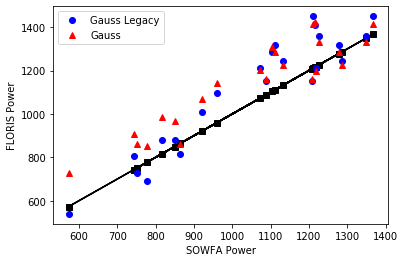

In [12]:
# How does this look in absolute terms?
fig, ax = plt.subplots()
ax.plot(df.sowfa_1,df.sowfa_1,'ks-')
ax.plot(df.sowfa_1,df.power_gauss_legacy,'bo-',label='Gauss Legacy',ls='None')
ax.plot(df.sowfa_1,df.power_gauss,'r^-',label='Gauss',ls='None')
ax.legend()
ax.set_xlabel('SOWFA Power')
ax.set_ylabel('FLORIS Power')

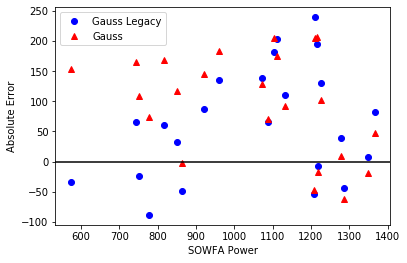

In [16]:
# Now in terms of error distributions
df['Gauss_Error'] = df.power_gauss - df.sowfa_1
df['Gauss_Legacy_Error'] = df.power_gauss_legacy - df.sowfa_1

fig, ax = plt.subplots()
# ax.plot(df.sowfa_1,df.sowfa_1,'ks-')
ax.plot(df.sowfa_1,df.Gauss_Legacy_Error,'bo-',label='Gauss Legacy',ls='None')
ax.plot(df.sowfa_1,df.Gauss_Error,'r^-',label='Gauss',ls='None')
ax.set_xlabel('SOWFA Power')
ax.set_ylabel('Absolute Error')
ax.axhline(0,color='k')
ax.legend()

Shows that previous version of gauss had reasonable calibration for deeper wakes but under-forecasted medium, probably not wide enough

## How do the overall errors compare

In [17]:
def compute_rms(df,floris_column):
    error_column = df[floris_column] 
    return np.sqrt(np.sum((error_column**2))/len(error_column))

In [18]:
print(compute_rms(df,'Gauss_Legacy_Error'))
print(compute_rms(df,'Gauss_Error'))

110.89770917628563
127.25599708134250419


New version without tuning is, as we know, worse

## Try to find an improved tuning for gauss ka/kb

In [21]:
# Define a tuning error function
(fi, floris_color, floris_label) = fi_dict['g']
fi_tune = copy.deepcopy(fi)
model_params = fi_tune.get_model_parameters()


def tuning_error_function(x): #where x = [ka, kb]
    
    # Change the parameters
    model_params['Wake Velocity Parameters']['ka'] = x[0] # 0.38
    model_params['Wake Velocity Parameters']['kb'] = x[1] # 0.004
    fi_tune.set_model_parameters(model_params,verbose=False)
    
    # Get the powers for each case
    t1_powers = np.zeros_like(df.sowfa_1.values)
    num_case = len(t1_powers)
    for idx, (i, row) in enumerate(df.iterrows()):

        # Determine free-stream wind speed column
        freestream_name = 'freestream_gauss'
        
        # Match the layout

        fi_tune.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                   wind_speed=[row[freestream_name]],
                                  turbulence_intensity=[row.freestream_ti])


        fi_tune.calculate_wake()
        
        t1_powers[idx] = fi_tune.get_turbine_power()[1]/1000.
        
    # Return the RMS error
    error_values = df.sowfa_1.values - t1_powers
    rms = np.sqrt(np.sum((error_values**2))/num_case)
    print(x,rms)
    return rms
        
        
    

In [22]:
# Find well fit values
result = minimize(tuning_error_function, x0=[.38, 0.004],bounds=[(0.05,0.5),(0.00001,0.1)])


[0.38  0.004] 127.2559970813425
[0.38000001 0.004     ] 127.25600137365291
[0.38       0.00400001] 127.25604701713502
[5.e-02 1.e-05] 173.85880823463407
[5.000001e-02 1.000000e-05] 173.85879895253765
[5.000e-02 1.001e-05] 173.85870348833384
[0.24120168 0.0023218 ] 70.46063771140827
[0.24120169 0.0023218 ] 70.46063919084249
[0.24120168 0.00232181] 70.46065533856239
[1.82050116e-01 1.00000000e-05] 81.5994100234384
[1.82050126e-01 1.00000000e-05] 81.5994058730447
[1.82050116e-01 1.00100000e-05] 81.59936302460356
[0.2253108  0.00170074] 68.58530346254511
[0.22531081 0.00170074] 68.58530353022282
[0.2253108  0.00170075] 68.58530487711663
[0.2251583 0.0015935] 68.57557868707933
[0.22515831 0.0015935 ] 68.57557866225788
[0.2251583  0.00159351] 68.57557902381275
[0.22613028 0.00148009] 68.56983423072872
[0.22613029 0.00148009] 68.56983418419222
[0.22613028 0.0014801 ] 68.56983429552186
[0.23673447 0.00043997] 68.53079129105994
[0.23673448 0.00043997] 68.53079115873487
[0.23673447 0.00043998] 6

In [23]:
result.x

array([2.43602076e-01, 1.00000000e-05])

In [122]:
result.x

array([2.43602076e-01, 1.00000000e-05])

In [24]:
# Add this tuned value to dictionary and compare
model_params['Wake Velocity Parameters']['ka'] = result.x[0] # 0.38
model_params['Wake Velocity Parameters']['kb'] = result.x[1] # 0.004
fi_tune.set_model_parameters(model_params)

fi_dict['g_tune'] = (fi_tune, 'm', 'gauss_tune')

Wake velocity parameter alpha set to 0.58
Wake velocity parameter beta set to 0.077
Wake velocity parameter calculate_VW_velocities set to True
Wake velocity parameter eps_gain set to 0.3
Wake velocity parameter ka set to 0.2436020759852764
Wake velocity parameter kb set to 1e-05
Wake velocity parameter use_yaw_added_recovery set to True
Wake velocity parameter yaw_recovery_alpha set to 0.03
Wake deflection parameter ad set to 0.0
Wake deflection parameter alpha set to 0.58
Wake deflection parameter bd set to 0.0
Wake deflection parameter beta set to 0.077
Wake deflection parameter eps_gain set to 0.3
Wake deflection parameter ka set to 0.38
Wake deflection parameter kb set to 0.004
Wake deflection parameter use_secondary_steering set to True
Wake turbulence parameter ti_ai set to 0.8
Wake turbulence parameter ti_constant set to 0.73
Wake turbulence parameter ti_downstream set to -0.275
Wake turbulence parameter ti_initial set to 0.1


In [25]:
# Recalculate
for floris_key in fi_dict:
    (fi, floris_color, floris_label) = fi_dict[floris_key]
    
    t1_powers = get_t1_powers(fi, floris_label, df)
    
    power_key = 'power_' + floris_label
    df[power_key] = t1_powers

gauss
gauss_legacy
gauss_tune


Text(0, 0.5, 'FLORIS Power')

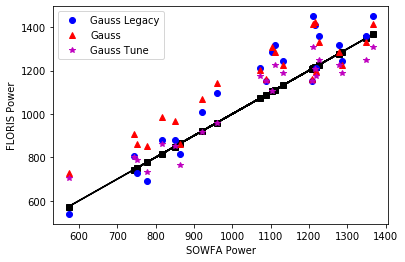

In [27]:
# How does this look in absolute terms?
fig, ax = plt.subplots()
ax.plot(df.sowfa_1,df.sowfa_1,'ks-')
ax.plot(df.sowfa_1,df.power_gauss_legacy,'bo-',label='Gauss Legacy',ls='None')
ax.plot(df.sowfa_1,df.power_gauss,'r^-',label='Gauss',ls='None')
ax.plot(df.sowfa_1,df.power_gauss_tune,'m*-',label='Gauss Tune',ls='None')
ax.legend()
ax.set_xlabel('SOWFA Power')
ax.set_ylabel('FLORIS Power')

In [28]:
df['Gauss_Tune_Error'] = df.power_gauss_tune - df.sowfa_1
print(compute_rms(df,'Gauss_Legacy_Error'))
print(compute_rms(df,'Gauss_Error'))
print(compute_rms(df,'Gauss_Tune_Error'))

110.89770917628563
127.25599708134250419
68.50384194753327102


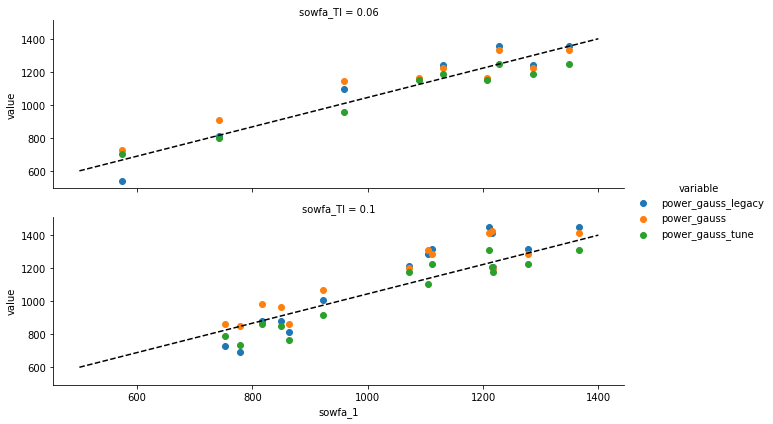

In [29]:
# Lets replot this by sowfa ti
df_sub = df[['sowfa_TI','sowfa_1','power_gauss_legacy','power_gauss','power_gauss_tune']]
df_sub = pd.melt(df_sub,id_vars=['sowfa_TI','sowfa_1'])
g = sns.FacetGrid(df_sub,row='sowfa_TI',hue='variable',aspect=3)
g.map(plt.scatter,'sowfa_1','value')
g.add_legend()
for ax in g.axes.flatten():
    ax.plot([500,1400],[600,1400],'k--')

In [136]:
# Save this new floris dictionary
fi_dict


{'g': (<floris.tools.floris_interface.FlorisInterface at 0x1159ea0d0>,
  'r',
  'gauss'),
 'gl': (<floris.tools.floris_interface.FlorisInterface at 0x11bba9e10>,
  'b',
  'gauss_legacy'),
 'g_tune': (<floris.tools.floris_interface.FlorisInterface at 0x120c59710>,
  'm',
  'gauss_tune')}

In [137]:
pickle.dump( fi_dict, open( "floris_models_2.p", "wb" ) )